# Refit rheology and generate values in ASPECT

Here I summarized what I learned from the other jupyter notebook refit_HK03.ipynb

In the previous notebook, I refit the prefactor A after both E and V are varied.

In this notebook, I took a different approach and condense the modification in $\dot{\epsilon_{correction}}$.
This variable is computed from a original flow law with a experimental referential state.
It is then carried into viscosity calculation to be a modification of $\dot{\epsilon_{correction}}^{1/n}$ 


In [1]:
import json
import os
import sys
import math
import argparse
import numpy as np
from scipy.special import erf
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from shutil import rmtree, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
from matplotlib import patches as mpatches 

plt.style.use('publication_lhy11009')

R = 8.314

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')

sys.path.append(os.path.join(ASPECT_LAB_DIR))

import shilofue.ThermalModel as ThermalModel
import shilofue.Rheology as Rheology

# import utilities in subdirectiory
sys.path.append(os.path.join(ASPECT_LAB_DIR, 'utilities', "python_scripts"))
import Utilities


#### First, load the rheology
By default, I use the flow law in Warren, Hansen 2023's table.
The difference from the Hirth, Kohlstedt 2003 flow law is a change of the prefactor by $3.5^r$.
I didnt' start with the activation volume of 1.9e-6 in the diffusion creep by Siber, Korato 2022.
First use the value from Hirth, Kohlstedt 2003 of 4e-6 and then modify the value on top of it.

In [2]:
# read the parameters from HK 03.
# water is in the water fugacity
# rheology = "HK03"
rheology = "WarrenHansen23"

rheology_prm_dict = Rheology.RHEOLOGY_PRM()
diffusion_creep_ori = getattr(rheology_prm_dict, rheology + "_diff")
dislocation_creep_ori = getattr(rheology_prm_dict, rheology + "_disl")
rheology_dict = {'diffusion': diffusion_creep_ori, 'dislocation': dislocation_creep_ori}

print("diffusion_creep: ", diffusion_creep_ori)
print("dislocation_creep: ", dislocation_creep_ori)

diffusion_creep:  {'A': 290000.0, 'p': 3.0, 'r': 1.0, 'n': 1.0, 'E': 335000.0, 'V': 4e-06}
dislocation_creep:  {'A': 20, 'p': 0.0, 'r': 1.2, 'n': 3.5, 'E': 480000.0, 'V': 1.1e-05}


#### Next: assign a modification

Next, I assign a modification to the original flow law.
The modification will be added to the original variables.

The strain_rate_correction term is then calculated from the reference state.

A Coh value is also assigned to adjust the rheology.
Note this factor is not in the ASPECT's rheology module.

In [3]:
# 1.9e-6
# Warren & Hansen 2023
# dE: 75e3, dV: -2.5 - (-1.7)e-6 (mid: -2.1)
diff_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 0.0, 'V': -2.1e-6}
# dE: 40e3, dV: 11e-6
disl_correction = {'A': 1.0, 'p': 0.0, 'r': 0.0, 'n': 0.0, 'E': 0.0, 'V': 3e-6}

Coh = 300.0 # H / 10^6 Si

# fit new rheology
stress_ref = 50.0 # MPa
# strain_rate_ref = 1e-5
P_ref = 100.0e6 # Pa
T_ref = 1250.0 + 273.15 # K
d_ref = 15.0 # mu m

strain_rate_diff_correction = Rheology.CreepStrainRate(diff_correction, stress_ref, P_ref, T_ref, d_ref, Coh)
strain_rate_disl_correction = Rheology.CreepStrainRate(disl_correction, stress_ref, P_ref, T_ref, d_ref, Coh)

# screen output
print("strain_rate_diff_correction:", strain_rate_diff_correction) 
print("strain_rate_disl_correction:", strain_rate_disl_correction) 

# apply the correction
diffusion_creep = diffusion_creep_ori.copy()
dislocation_creep = dislocation_creep_ori.copy()

diffusion_creep['E'] += diff_correction['E']
diffusion_creep['V'] += diff_correction['V']
dislocation_creep['E'] += disl_correction['E']
dislocation_creep['V'] += disl_correction['V']
diffusion_creep['A'] /= strain_rate_diff_correction
dislocation_creep['A'] /= strain_rate_disl_correction

# screen output
print("diffusion_creep: ", diffusion_creep)
print("dislocation_creep: ", dislocation_creep)

strain_rate_diff_correction: 1.0167213969887408
strain_rate_disl_correction: 0.9765882188461675
diffusion_creep:  {'A': 285230.5467937462, 'p': 3.0, 'r': 1.0, 'n': 1.0, 'E': 335000.0, 'V': 1.9e-06}
dislocation_creep:  {'A': 20.479460650907573, 'p': 0.0, 'r': 1.2, 'n': 3.5, 'E': 480000.0, 'V': 1.4e-05}


#### Last: Lower mantle rheology with a jump, plots, profiles

Then I call a function "MantleRheology" to derive the whole mantle rheology profile.
The mantle profile viscosity profile is plotted and saved.
The aspect importable rheology is saved in a dict and then returned.

In [4]:
jump_lower_mantle = 60.0

Operator = Rheology.RHEOLOGY_OPR()

source_dir = os.path.join(ASPECT_LAB_DIR, 'tests', 'integration', 'fixtures', 'test_rheology')
da_file = os.path.join(source_dir, "depth_average.txt")
Operator.ReadProfile(da_file)

fig_path = os.path.join(ASPECT_LAB_DIR, "results", "%s_coh%.1f_dEdiff%.2e_dVdiff%.2e_dEdisl%.2e_dVdisl%.2e_1"\
                                                 % (rheology, Coh, diff_correction['E'], diff_correction['V'], disl_correction['E'], disl_correction['V']))\
                                                  + ".png"

rheology_aspect, constrained_viscosity_profile = Operator.MantleRheology(assign_rheology=True, diffusion_creep=diffusion_creep, dislocation_creep=dislocation_creep, save_profile=1,\
        use_effective_strain_rate=True, save_json=False, fig_path=fig_path, Coh=Coh, jump_lower_mantle=jump_lower_mantle, save_pdf=True)

depths0 = constrained_viscosity_profile['depth']
viscosity0 = constrained_viscosity_profile['composite']
viscosity0_diff = constrained_viscosity_profile['diffusion']
viscosity0_disl = constrained_viscosity_profile['dislocation']
visc0_func = interp1d(depths0, viscosity0, assume_sorted=True)
visc_diff0_func = interp1d(depths0, viscosity0_diff, assume_sorted=True)
visc_disl0_func = interp1d(depths0, viscosity0_disl, assume_sorted=True)


print("constrained_rheology_aspect (type):", type(rheology_aspect))
print("constrained_rheology_aspect:", rheology_aspect)

New figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/WarrenHansen23_coh300.0_dEdiff0.00e+00_dVdiff-2.10e-06_dEdisl0.00e+00_dVdisl3.00e-06_1.png
New figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/mantle_profile_v1_HK03_wet_mod_dEdiff0.0000e+00_dEdisl0.0000e+00_dVdiff0.000000e+00_dVdisl0.0000e+00_dAdiff1.0000e+00_dAdisl1.0000e+00.pdf
constrained_rheology_aspect (type): <class 'dict'>
constrained_rheology_aspect: {'diffusion_creep': {'A': 1.2835374605718582e-16, 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 335000.0, 'V': 1.9e-06}, 'dislocation_creep': {'A': 1.1385624273269513e-16, 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 480000.0, 'V': 1.4e-05}, 'diffusion_lm': {'A': 5.3485492972674075e-18, 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 335000.0, 'V': 3e-06}}


#### Constrains

##### The Haskell 1935 (ice glacial rebound), reviewed by F&M 96

This is the constraint from the so-called Fennoscandian relaxation spectrum (FRS)

The average of the mantle rheology down to 1400 km is somewhere 0.65-1.1e21.

In the following section, I computed an average by the log value between 100 km and 1400 km

In [5]:
# Next, we visit some constraints for whole manlte rheology 
# to see whether we match them
# The haskel constraint
radius = 6371e3
lith_depth = 100e3
integral_depth = 1400e3
mask_integral = (depths0 > lith_depth) & (depths0 < integral_depth)
integral_cores = 4 * np.pi * (radius - depths0)**2.0
# upper mantle
# use harmonic average
# lower mantle
integral = np.trapz(integral_cores[mask_integral] * np.log10(viscosity0[mask_integral]), depths0[mask_integral])
volume = np.trapz(integral_cores[mask_integral], depths0[mask_integral])
average_log_eta = integral / volume
average_eta = 10**average_log_eta

print("Average (by log) over the 1400 km depth: %.4e\n" % average_eta)

# rheology at 250 km depth
depth_switch = 250e3
visc_diff_switch = visc_diff0_func(depth_switch)
visc_disl_switch = visc_disl0_func(depth_switch)
visc_switch = visc0_func(depth_switch)

print("Diffusion creep at %.2d km: %.4e" % (depth_switch, visc_diff_switch))
print("Dislocation creep at %.2d km: %.4e" % (depth_switch, visc_disl_switch))
print("Viscosity at %.2d km: %.4e\n" % (depth_switch, visc_switch))

# lower mantle
depth_lm = 1500e3
visc_lm = visc0_func(depth_lm)
print("Viscosity at %.2d km: %.4e" % (depth_lm, visc_lm))

Average (by log) over the 1400 km depth: 1.7105e+21

Diffusion creep at 250000 km: 3.3321e+20
Dislocation creep at 250000 km: 1.5178e+20
Viscosity at 250000 km: 1.0428e+20

Viscosity at 1500000 km: 2.1750e+22


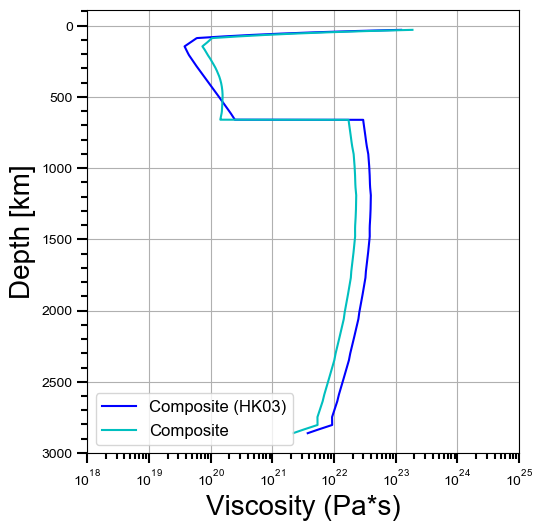

In [6]:
rheology_aspect_hk03, constrained_viscosity_profile_hk03 = Operator.MantleRheology(rheology="HK03", use_effective_strain_rate=True, save_json=False, Coh=Coh, jump_lower_mantle=jump_lower_mantle)


depths_hk03 = constrained_viscosity_profile_hk03['depth']
viscosity_hk03 = constrained_viscosity_profile_hk03['composite']

visc0_hk03_func = interp1d(depths_hk03, viscosity_hk03, assume_sorted=True)


fig = plt.figure(tight_layout=True, figsize=[10, 10])
gs = gridspec.GridSpec(2, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax0.semilogx(viscosity_hk03, depths_hk03/1e3, 'b-', label='Composite (HK03)')
ax0.semilogx(viscosity0, depths0/1e3, 'c-', label='Composite')
ax0.invert_yaxis()
ax0.set_xlim([1e18,1e25])
# ax0.set_ylim(ylim)
ax0.grid()
ax0.set_ylabel('Depth [km]')
ax0.set_xlabel("Viscosity (Pa*s)")
ax0.legend()

#### Strength Profile of the oceanic lithosphere

/home/lochy/ASPECT_PROJECT/aspectLib/shilofue/Rheology.py:2122: RuntimeWarning: overflow encountered in exp
  expo = np.exp(exponential)


Diffusion creep (in UI): 
{'A': 1.2835374605718582e-16, 'd': 0.01, 'n': 1.0, 'm': 3.0, 'E': 335000.0, 'V': 1.9e-06}
Dislocation creep (in UI): 
{'A': 1.1385624273269513e-16, 'd': 0.01, 'n': 3.5, 'm': 0.0, 'E': 480000.0, 'V': 1.4e-05}
Peierls creep (not in UI): 
{'q': 1.0, 'p': 0.5, 'n': 2.0, 'sigp0': 5900.0, 'A': 1.4e-07, 'E': 320000.0, 'V': 0.0, 'Tref': 873.0, 'Pref': 4500000000.0}
save figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/Peierls_Yielding_Compare_Strength_Profile_1.00e-14.pdf


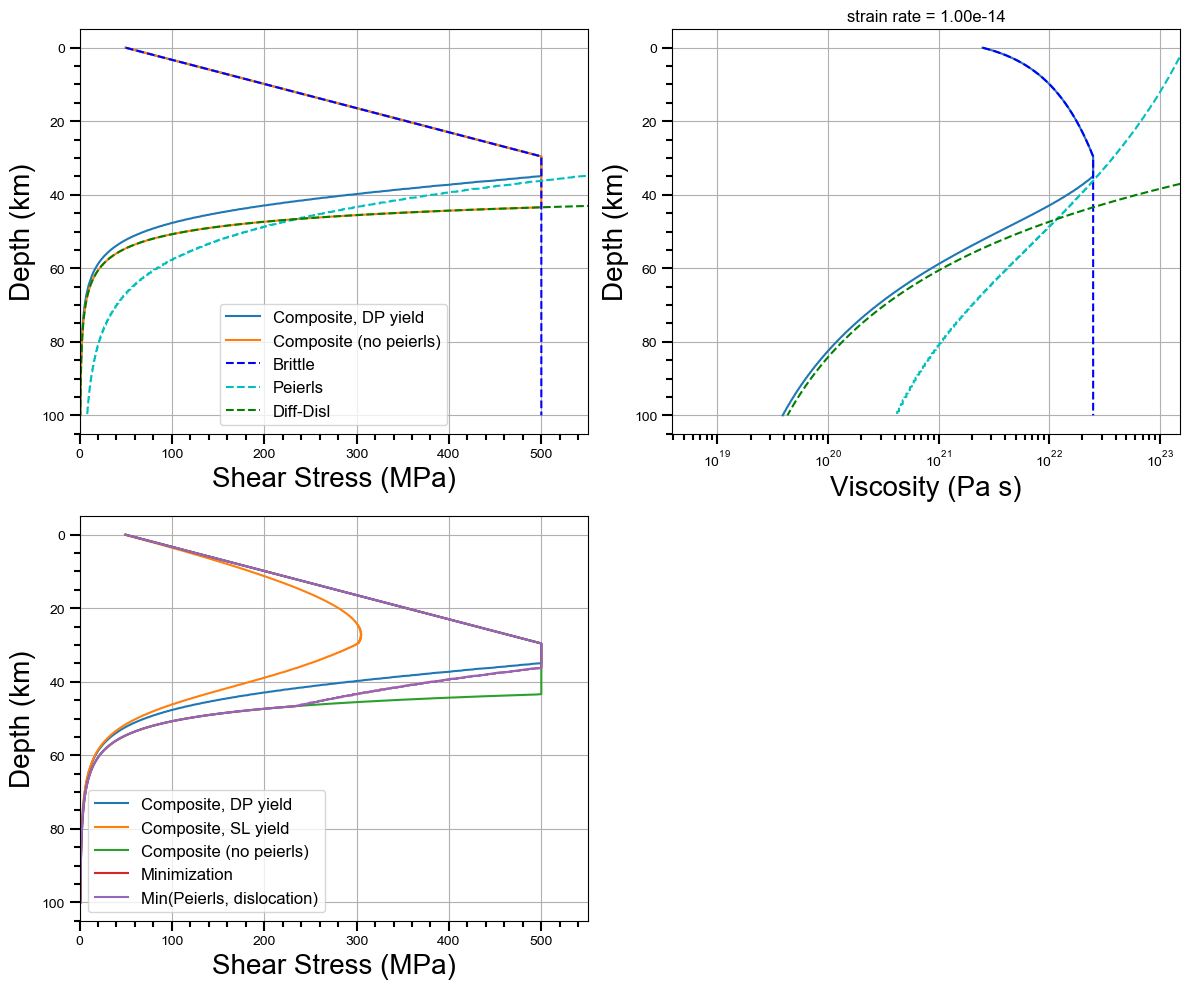

In [7]:
# define global parameters
g = 9.81
rho_m = 3300.0 # mantle density
year = 365.25 * 24 * 3600.0  # s in year
Myr = 1e6 * year

# pressure profile
zs_test = np.linspace(0.0, 100e3, 1000)
Ps = zs_test * rho_m * g

# thermal model
age = 80 * Myr
PlateModel = ThermalModel.PLATE_MODEL(150e3, 1e-6, 273.15, 1673.0)
Ts = PlateModel.T(zs_test, age)

# strain rate to use
strain_rate = 1e-14

# brittle yielding
tau_0 = 50e6
tau_m = 500e6
friction = 0.47
taus_test_brittle = Rheology.CoulumbYielding(Ps, tau_0, friction)
mask_limit = (taus_test_brittle > tau_m)
taus_test_brittle[mask_limit] = tau_m
eta_brittle = taus_test_brittle / 2.0 / strain_rate



# diffusion & dislocation creep
# here I took the parameterization for my 2d cases
da_file = os.path.join(ASPECT_LAB_DIR, 'tests', 'integration', 'fixtures', 'test_rheology', 'depth_average.txt')
assert(os.path.isfile(da_file))
Operator = Rheology.RHEOLOGY_OPR()
Operator.ReadProfile(da_file)

diffusion_aspect = rheology_aspect['diffusion_creep']
eta_diffusion = Rheology.CreepRheologyInAspectViscoPlastic(diffusion_aspect, strain_rate, Ps, Ts)
taus_diffusion = 2 * strain_rate * eta_diffusion
dislocation_aspect = rheology_aspect['dislocation_creep']
eta_dislocation = Rheology.CreepRheologyInAspectViscoPlastic(dislocation_aspect, strain_rate, Ps, Ts)
taus_dislocation = 2 * strain_rate * eta_dislocation

eta_dfds = 1.0 / (1.0 / eta_diffusion + 1.0 / eta_dislocation)
taus_dfds = 2 * strain_rate * eta_dfds


# peierls creep
dV = dislocation_aspect['V']
creep = Rheology.GetPeierlsRheology("MK10")
taus_peierls = np.zeros(zs_test.size) # Mpa
for i in range(zs_test.size):
    taus_peierls[i] = Rheology.PeierlsCreepStress(creep, strain_rate, Ps[i], Ts[i], dV=dV)
eta_peierls = taus_peierls * 1e6 / 2.0 / strain_rate

# print the value in the flow law
print("Diffusion creep (in UI): ")
print(diffusion_aspect)
print("Dislocation creep (in UI): ")
print(dislocation_aspect)
print("Peierls creep (not in UI): ")
print(creep)

# get the composite rheology
eta = 1.0 / (1.0/eta_brittle + 1.0/eta_peierls + 1.0/eta_dfds)
eta1 = np.minimum(eta_peierls, eta_dfds)  # minimum
eta1 = np.minimum(eta_brittle, eta1)
eta2 = np.minimum(eta_brittle, 1.0 / (1.0 / eta_peierls + 1.0/eta_dfds)) # DP yield
eta3 = np.minimum(eta_brittle, 1.0/(1.0 / np.minimum(eta_peierls, eta_dislocation) + 1.0 / eta_diffusion)) # competing Peierls and Dislocation
eta_nopc = np.minimum(eta_brittle, eta_dfds)
taus = 2 * strain_rate * eta
taus1 = 2 * strain_rate * eta1
taus2 = 2 * strain_rate * eta2
taus3 = 2 * strain_rate * eta3
taus_nopc = 2 * strain_rate * eta_nopc

# get the minimum
taus_minimum = np.minimum(taus_test_brittle, taus_peierls*1e6)
taus_minimum = np.minimum(taus_minimum, taus_dfds)

fig = plt.figure(tight_layout=True, figsize=(12, 10))
gs = gridspec.GridSpec(2, 2)

# shear stress vs depth
ax = fig.add_subplot(gs[0, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus_test_brittle/1e6, zs_test/1e3, 'b--', label="Brittle")
ax.plot(taus_peierls, zs_test/1e3, 'c--', label="Peierls") # peierls is MPa
ax.plot(taus_dfds/1e6, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

# viscosity vs depth
ax = fig.add_subplot(gs[0, 1])
ax.semilogx(eta2, zs_test/1e3, label="Composite, DP yield")
ax.semilogx(eta_brittle, zs_test/1e3, 'b--', label="Brittle")
ax.semilogx(eta_peierls, zs_test/1e3, 'c--', label="Peierls")
ax.semilogx(eta_dfds, zs_test/1e3, 'g--', label="Diff-Disl")
ax.set_xlabel("Viscosity (Pa s)")
ax.set_xlim([np.amin(eta)/10.0, np.amax(eta)*10.0])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.set_title("strain rate = %.2e" % strain_rate)

# shear stress vs depth
ax = fig.add_subplot(gs[1, 0])
ax.plot(taus2/1e6, zs_test/1e3, label="Composite, DP yield")
ax.plot(taus/1e6, zs_test/1e3, label="Composite, SL yield")
ax.plot(taus_nopc/1e6, zs_test/1e3, label="Composite (no peierls)")
ax.plot(taus1/1e6, zs_test/1e3, label="Minimization")
ax.plot(taus3/1e6, zs_test/1e3, label="Min(Peierls, dislocation)")
ax.set_xlabel("Shear Stress (MPa)")
ax.set_xlim([0, tau_m/1e6 * 1.1])
ax.invert_yaxis()
ax.set_ylabel("Depth (km)")
ax.grid()
ax.legend()

fig_path = os.path.join(RESULT_DIR, "Peierls_Yielding_Compare_Strength_Profile_%.2e.pdf" % strain_rate)
fig.savefig(fig_path)
print("save figure: %s" % fig_path)